# Assignment 4 - RNN classification and Named Entity Recognition

In [1]:
%matplotlib inline
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras import models
from keras import layers
from keras.datasets import reuters
from keras.layers import Bidirectional, Dense, Embedding, LSTM, SimpleRNN, GRU
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
keras.__version__

'2.7.0'

In [94]:
# I'm working in Colab - Use the drive folder to write results file
try:
    from google.colab import drive 
    drive.mount('/content/drive', force_remount=True)
    %cd drive/My Drive/Colab Notebooks/nlp_github/CS-6120_saulniern/Assignment4/
except:
    pass

step_1_metrics_out = os.path.join(os.getcwd(), 'ReadmeProblem1.txt')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/nlp_github/CS-6120_saulniern/Assignment4


## 1. RNNs and Classification

## Step 1. Examine the data

In [3]:
(input_train, y_train), (input_test, y_test) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [4]:
# Report the number training samples
num_train_samples = len(input_train)
print('Number of training samples: {}'.format(num_train_samples))

Number of training samples: 8982


In [5]:
# Report the number test samples
num_test_samples = len(input_test)
print('Number of test samples: {}'.format(num_test_samples))

Number of test samples: 2246


In [6]:
def createBarChart(X, y, title, xlabel, ylabel):
    """Plot a bar chart of the specified classes and their counts."""
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(X)
    ax.bar(X, y, align='center', alpha=0.7)
    for class_index,count in enumerate(y):
        plt.text(x=class_index, y=count, s=f"{count}", ha='center', fontdict=dict(fontsize=8))
    plt.show()

In [7]:
# Get list of unique class indices, and the number of occurrences of each class, for the training data
unique_train_classes, train_class_counts = np.unique(y_train, return_counts=True)

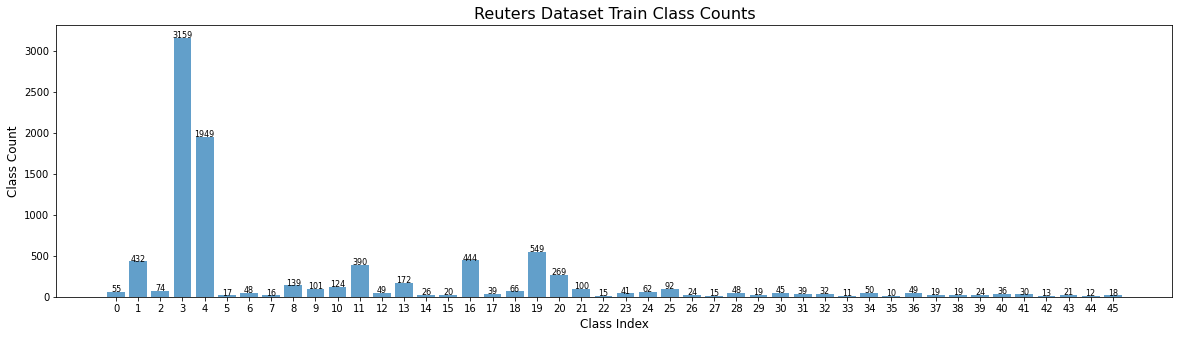

In [8]:
# Plot the training set classes with their counts
plot_title = 'Reuters Dataset Train Class Counts'
xlabel = 'Class Index'
ylabel = 'Class Count'
createBarChart(unique_train_classes, train_class_counts, plot_title, xlabel, ylabel)

In [9]:
# Get the unique classes, and their counts, from the test set
unique_test_classes, test_class_counts = np.unique(y_test, return_counts=True)

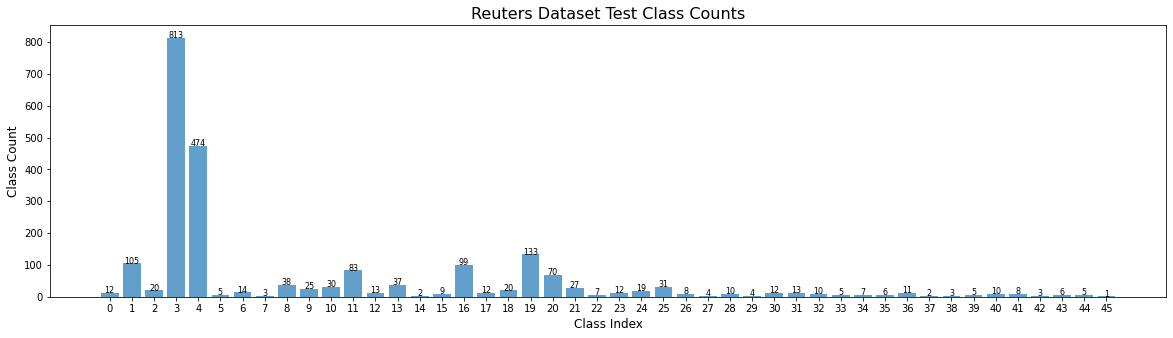

In [10]:
# Plot the test set classes with their counts
plot_title = 'Reuters Dataset Test Class Counts'
xlabel = 'Class Index'
ylabel = 'Class Count'
createBarChart(unique_test_classes, test_class_counts, plot_title, xlabel, ylabel)

In [11]:
# Report the average training sample length
length_of_all_train_samples = 0
for train_sample in input_train:
    length_of_all_train_samples += len(train_sample)
average_train_sample_length = length_of_all_train_samples / len(input_train)
print('Average training sample length: {}'.format(average_train_sample_length))

Average training sample length: 145.5398574927633


In [12]:
# Report the average test sample length
length_of_all_test_samples = 0
for test_sample in input_test:
    length_of_all_test_samples += len(test_sample)
average_test_sample_length = length_of_all_test_samples / len(input_test)
print('Average test sample length: {}'.format(average_test_sample_length))

Average test sample length: 147.66117542297417


In [13]:
# Get average sample lengths for each train class
train_sample_length_sums = {train_class: 0 for train_class in unique_train_classes}

for index,train_sample in np.ndenumerate(input_train):
    class_index =  y_train[index]
    train_sample_length_sums[class_index] += len(train_sample)
    
average_train_sample_lengths = []
for index,class_index in enumerate(train_sample_length_sums.keys()):
    average_sample_length = round(train_sample_length_sums[class_index] / train_class_counts[index], 2)
    average_train_sample_lengths.append(average_sample_length)

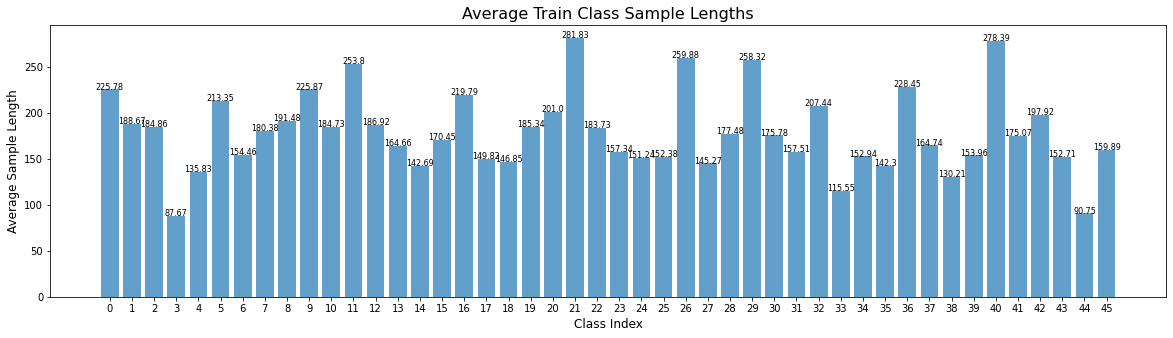

In [14]:
# Plot the average training class sample lengths
plot_title = 'Average Train Class Sample Lengths'
xlabel = 'Class Index'
ylabel = 'Average Sample Length'
createBarChart(unique_train_classes, average_train_sample_lengths, plot_title, xlabel, ylabel)

In [15]:
# Get the average sample lengths for each test class
test_sample_length_sums = {test_class: 0 for test_class in unique_test_classes}

for index,test_sample in np.ndenumerate(input_test):
    class_index =  y_test[index]
    test_sample_length_sums[class_index] += len(test_sample)
    
average_test_sample_lengths = []
for index,class_index in enumerate(test_sample_length_sums.keys()):
    average_sample_length = round(test_sample_length_sums[class_index] / test_class_counts[index], 2)
    average_test_sample_lengths.append(average_sample_length)

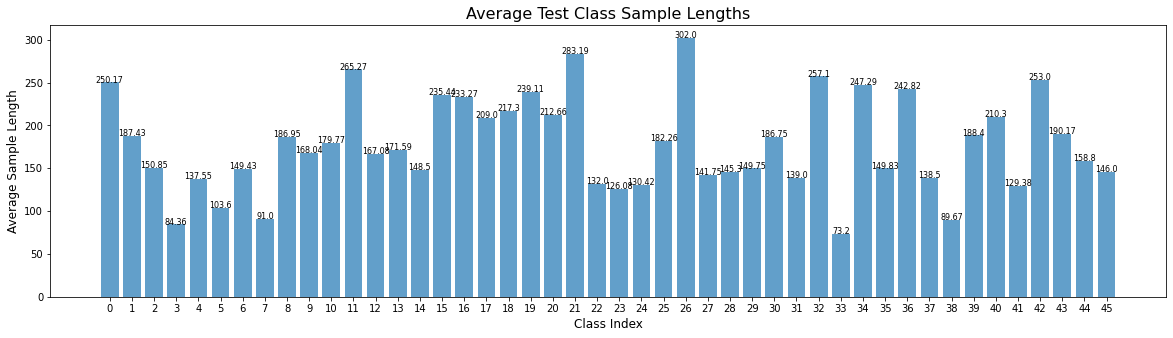

In [16]:
# Plot the average test class sample lengths
plot_title = 'Average Test Class Sample Lengths'
xlabel = 'Class Index'
ylabel = 'Average Sample Length'
createBarChart(unique_test_classes, average_test_sample_lengths, plot_title, xlabel, ylabel)

In [17]:
# Get the differences in average sample length in the training set vs. test set for each class 
train_test_avg_sample_length_diffs = []
for i in range(0, len(average_test_sample_lengths)):
    train_test_avg_sample_length_diffs.append(round(abs(average_train_sample_lengths[i] - average_test_sample_lengths[i]), 2))

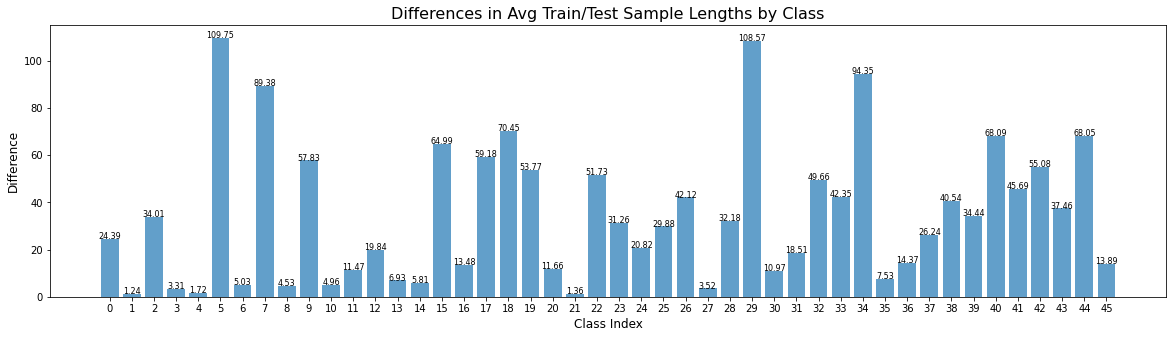

In [18]:
# Plot the differences in average sample length in the training set vs. test set for each class 
plot_title = 'Differences in Avg Train/Test Sample Lengths by Class'
xlabel = 'Class Index'
ylabel = 'Difference'
createBarChart(unique_train_classes, train_test_avg_sample_length_diffs, plot_title, xlabel, ylabel)

In [19]:
# Get size of the unique vocabulary for each train class
train_unique_vocab = {train_class: [] for train_class in unique_train_classes}

for index,train_sample in np.ndenumerate(input_train):
    class_index =  y_train[index]
    for word_index in train_sample:
        if not word_index in train_unique_vocab[class_index]:
            train_unique_vocab[class_index].append(word_index)

train_class_vocab_sizes = []
for class_index in train_unique_vocab.keys():
    vocab_size = len(train_unique_vocab[class_index])
    train_class_vocab_sizes.append(vocab_size)

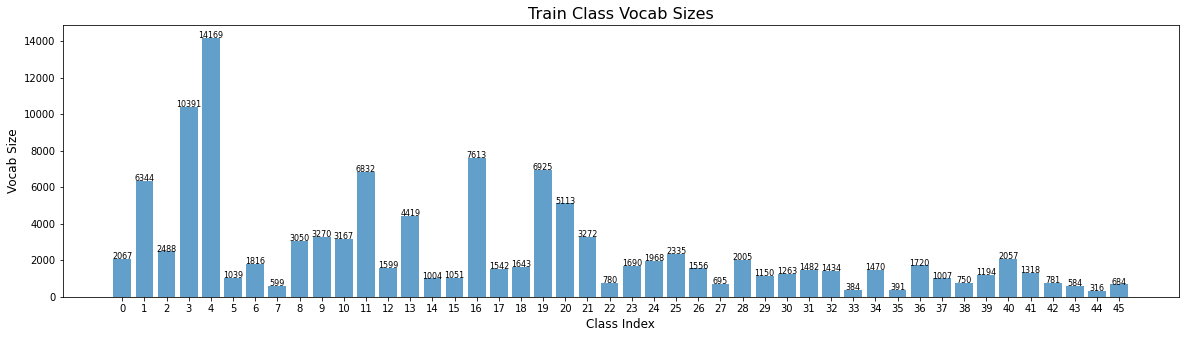

In [20]:
# Plot the vocab size of each train class
plot_title = 'Train Class Vocab Sizes'
xlabel = 'Class Index'
ylabel = 'Vocab Size'
createBarChart(unique_train_classes, train_class_vocab_sizes, plot_title, xlabel, ylabel)

In [21]:
# Get size of the unique vocabulary for each test class
test_unique_vocab = {test_class: [] for test_class in unique_test_classes}

for index,test_sample in np.ndenumerate(input_test):
    class_index =  y_test[index]
    for word_index in test_sample:
        if not word_index in test_unique_vocab[class_index]:
            test_unique_vocab[class_index].append(word_index)

test_class_vocab_sizes = []
for class_index in test_unique_vocab.keys():
    vocab_size = len(test_unique_vocab[class_index])
    test_class_vocab_sizes.append(vocab_size)

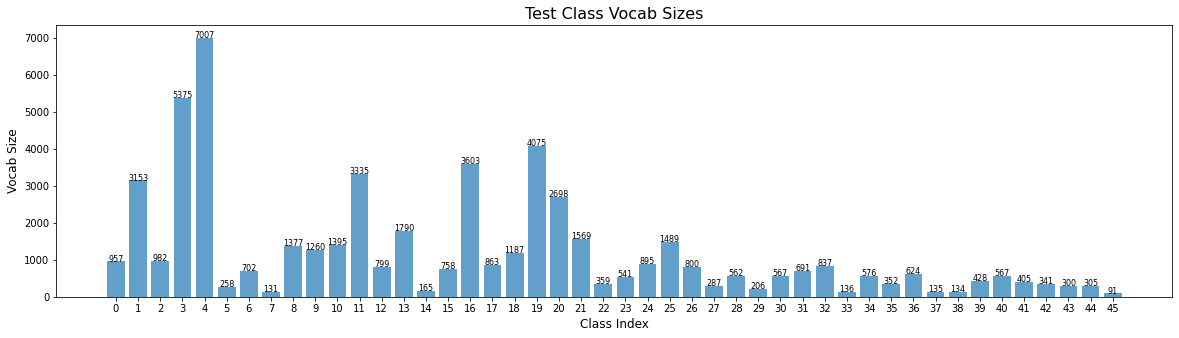

In [22]:
# Plot the vocab size of each train class
plot_title = 'Test Class Vocab Sizes'
xlabel = 'Class Index'
ylabel = 'Vocab Size'
createBarChart(unique_test_classes, test_class_vocab_sizes, plot_title, xlabel, ylabel)

In [23]:
def writeClassMetric(file, metric_list, header):
    file.write(header)
    for index,value in enumerate(metric_list):
        line = str(index) + ': ' + str(value) + '\n'
        file.write(line)

In [24]:
# Record metrics in output file
step_1_metrics_out = os.path.join(os.getcwd(), 'ReadmeProblem1.txt')
with open(step_1_metrics_out, 'w') as file:
    train_sample_count_line = 'Number of training samples: ' + str(num_train_samples) + '\n'
    file.write(train_sample_count_line)
    test_sample_count_line = 'Number of test samples: ' + str(num_test_samples) + '\n'
    file.write(test_sample_count_line)
    
    writeClassMetric(file, train_class_counts, '\nTraining Class Counts\n')
    writeClassMetric(file, test_class_counts, '\nTest Class Counts\n')
    writeClassMetric(file, average_train_sample_lengths, '\nTraining Class Average Sample Length\n')   
    writeClassMetric(file, average_test_sample_lengths, '\nTest Class Average Sample Length\n')
    writeClassMetric(file, train_test_avg_sample_length_diffs, '\nDifferences in Avg Sample Length Between Training and Test Class Instances\n')
    writeClassMetric(file, train_class_vocab_sizes, '\nTrain Class Vocab Sizes\n')
    writeClassMetric(file, test_class_vocab_sizes, '\nTest Class Vocab Sizes\n')

## Step 2. Newswire Classification Experiments

In [25]:
def plotTrainingAndValidationLoss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']  
    epochs = range(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

In [26]:
def plotTrainingAndValidationAccuracy(history, metric_string='accuracy'):
    acc = history.history[metric_string]
    val_acc = history.history['val_' + metric_string]
    epochs = range(1, len(acc) + 1)
    plt.clf()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [27]:
def vectorize_sequences(sequences, dimension=31000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [28]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [29]:
# Vectorize the training and test data
x_train = vectorize_sequences(input_train)
x_test = vectorize_sequences(input_test)

In [30]:
# Vectorize the training and test labels
one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)

In [31]:
# Split the training data, using 1/3 of the data as a validation set
partial_X_train, x_val, partial_y_train, y_val = train_test_split(x_train, one_hot_train_labels, test_size=0.33)

In [32]:
# Create the first model, taken from the class notebook
model_1 = models.Sequential()
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(46, activation='softmax'))

model_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
# Train the first model for 20 epochs
model_1_history = model_1.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 3s 157ms/step - loss: 2.9363 - accuracy: 0.5102 - val_loss: 2.0235 - val_accuracy: 0.6152
Epoch 2/20
12/12 [==============================] - 1s 122ms/step - loss: 1.6080 - accuracy: 0.6864 - val_loss: 1.4817 - val_accuracy: 0.6877
Epoch 3/20
12/12 [==============================] - 1s 116ms/step - loss: 1.1239 - accuracy: 0.7778 - val_loss: 1.2695 - val_accuracy: 0.7400
Epoch 4/20
12/12 [==============================] - 1s 117ms/step - loss: 0.8544 - accuracy: 0.8368 - val_loss: 1.1544 - val_accuracy: 0.7639
Epoch 5/20
12/12 [==============================] - 1s 115ms/step - loss: 0.6691 - accuracy: 0.8677 - val_loss: 1.1150 - val_accuracy: 0.7646
Epoch 6/20
12/12 [==============================] - 1s 119ms/step - loss: 0.5277 - accuracy: 0.8961 - val_loss: 1.0539 - val_accuracy: 0.7788
Epoch 7/20
12/12 [==============================] - 1s 117ms/step - loss: 0.4201 - accuracy: 0.9174 - val_loss: 1.0111 - val_accuracy: 0.7919
Epoch 

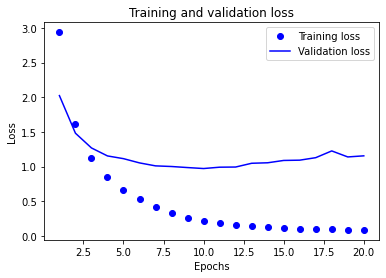

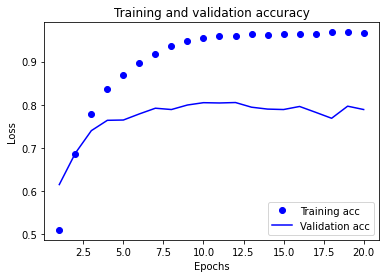

In [34]:
# Plot model_1's loss and accuracy curves
plotTrainingAndValidationLoss(model_1_history)
plotTrainingAndValidationAccuracy(model_1_history)

In [35]:
# Create the second model, which has a single dense layer
model_2 = models.Sequential()
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(46, activation='softmax'))

model_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
# Train the second model for 20 epochs
model_2_history = model_2.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 2s 142ms/step - loss: 2.7580 - accuracy: 0.5258 - val_loss: 1.9932 - val_accuracy: 0.6462
Epoch 2/20
12/12 [==============================] - 1s 101ms/step - loss: 1.5961 - accuracy: 0.7077 - val_loss: 1.4997 - val_accuracy: 0.7069
Epoch 3/20
12/12 [==============================] - 1s 101ms/step - loss: 1.1318 - accuracy: 0.7816 - val_loss: 1.2691 - val_accuracy: 0.7447
Epoch 4/20
12/12 [==============================] - 1s 101ms/step - loss: 0.8570 - accuracy: 0.8366 - val_loss: 1.1480 - val_accuracy: 0.7690
Epoch 5/20
12/12 [==============================] - 1s 101ms/step - loss: 0.6715 - accuracy: 0.8762 - val_loss: 1.0667 - val_accuracy: 0.7828
Epoch 6/20
12/12 [==============================] - 1s 100ms/step - loss: 0.5363 - accuracy: 0.9036 - val_loss: 1.0092 - val_accuracy: 0.7970
Epoch 7/20
12/12 [==============================] - 1s 100ms/step - loss: 0.4334 - accuracy: 0.9249 - val_loss: 0.9719 - val_accuracy: 0.7973
Epoch 

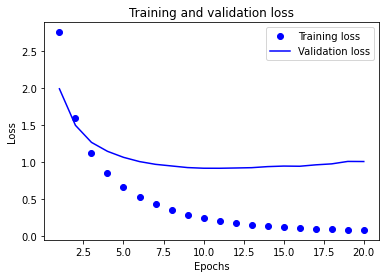

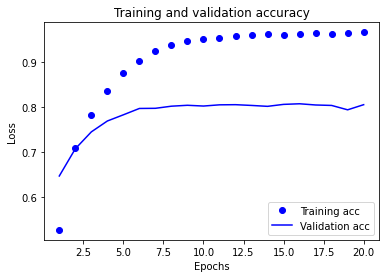

In [37]:
# Plot model_2's loss and accuracy curves
plotTrainingAndValidationLoss(model_2_history)
plotTrainingAndValidationAccuracy(model_2_history)

In [38]:
# Create the third model, which has a single dense layer with only 10 nodes
model_3 = models.Sequential()
model_3.add(layers.Dense(10, activation='relu'))
model_3.add(layers.Dense(46, activation='softmax'))

model_3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# Train the third model for 20 epochs
model_3_history = model_3.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 2s 95ms/step - loss: 3.5843 - accuracy: 0.2852 - val_loss: 3.3384 - val_accuracy: 0.4128
Epoch 2/20
12/12 [==============================] - 1s 63ms/step - loss: 3.1102 - accuracy: 0.5597 - val_loss: 2.9520 - val_accuracy: 0.6411
Epoch 3/20
12/12 [==============================] - 1s 62ms/step - loss: 2.7006 - accuracy: 0.6719 - val_loss: 2.6033 - val_accuracy: 0.6465
Epoch 4/20
12/12 [==============================] - 1s 62ms/step - loss: 2.3425 - accuracy: 0.6766 - val_loss: 2.3045 - val_accuracy: 0.6445
Epoch 5/20
12/12 [==============================] - 1s 62ms/step - loss: 2.0452 - accuracy: 0.6814 - val_loss: 2.0635 - val_accuracy: 0.6479
Epoch 6/20
12/12 [==============================] - 1s 65ms/step - loss: 1.8050 - accuracy: 0.6912 - val_loss: 1.8727 - val_accuracy: 0.6503
Epoch 7/20
12/12 [==============================] - 1s 63ms/step - loss: 1.6118 - accuracy: 0.7008 - val_loss: 1.7219 - val_accuracy: 0.6658
Epoch 8/20
12

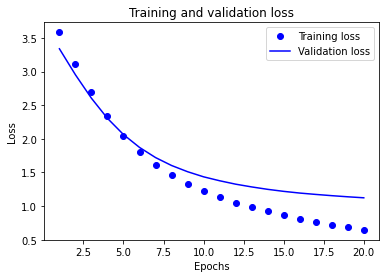

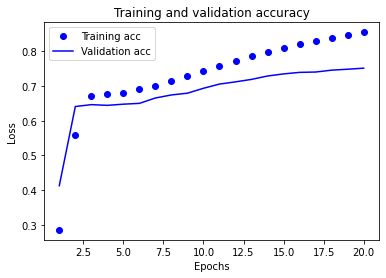

In [40]:
# Plot model_3's loss and accuracy curves
plotTrainingAndValidationLoss(model_3_history)
plotTrainingAndValidationAccuracy(model_3_history)

In [41]:
# Create the fourth model, which has three dense layers with 30 nodes each
model_4 = models.Sequential()
model_4.add(layers.Dense(30, activation='relu'))
model_4.add(layers.Dense(30, activation='relu'))
model_4.add(layers.Dense(30, activation='relu'))
model_4.add(layers.Dense(46, activation='softmax'))

model_4.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Train the fourth model for 20 epochs
model_4_history = model_4.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 2s 110ms/step - loss: 3.2968 - accuracy: 0.3618 - val_loss: 2.6309 - val_accuracy: 0.4843
Epoch 2/20
12/12 [==============================] - 1s 76ms/step - loss: 2.2283 - accuracy: 0.5352 - val_loss: 1.9684 - val_accuracy: 0.5713
Epoch 3/20
12/12 [==============================] - 1s 76ms/step - loss: 1.7132 - accuracy: 0.6083 - val_loss: 1.7169 - val_accuracy: 0.6132
Epoch 4/20
12/12 [==============================] - 1s 73ms/step - loss: 1.4519 - accuracy: 0.6653 - val_loss: 1.5452 - val_accuracy: 0.6388
Epoch 5/20
12/12 [==============================] - 1s 74ms/step - loss: 1.2544 - accuracy: 0.7078 - val_loss: 1.4372 - val_accuracy: 0.6725
Epoch 6/20
12/12 [==============================] - 1s 74ms/step - loss: 1.0812 - accuracy: 0.7485 - val_loss: 1.3440 - val_accuracy: 0.6971
Epoch 7/20
12/12 [==============================] - 1s 75ms/step - loss: 0.9341 - accuracy: 0.7874 - val_loss: 1.2733 - val_accuracy: 0.7248
Epoch 8/20
1

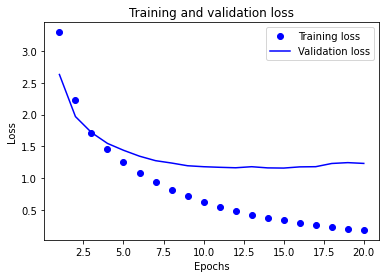

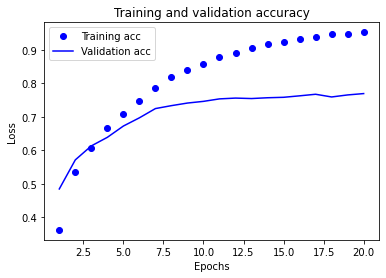

In [43]:
# Plot model_4's loss and accuracy curves
plotTrainingAndValidationLoss(model_4_history)
plotTrainingAndValidationAccuracy(model_4_history)

In [44]:
# Create the fifth model, which has five dense layers with 60 nodes each
model_5 = models.Sequential()
model_5.add(layers.Dense(60, activation='relu'))
model_5.add(layers.Dense(60, activation='relu'))
model_5.add(layers.Dense(60, activation='relu'))
model_5.add(layers.Dense(60, activation='relu'))
model_5.add(layers.Dense(60, activation='relu'))
model_5.add(layers.Dense(46, activation='softmax'))

model_5.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# Train the fifth model for 20 epochs
model_5_history = model_5.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 2s 140ms/step - loss: 2.9123 - accuracy: 0.3327 - val_loss: 2.0876 - val_accuracy: 0.3811
Epoch 2/20
12/12 [==============================] - 1s 103ms/step - loss: 1.7445 - accuracy: 0.5476 - val_loss: 1.5697 - val_accuracy: 0.6408
Epoch 3/20
12/12 [==============================] - 1s 103ms/step - loss: 1.2896 - accuracy: 0.6984 - val_loss: 1.4359 - val_accuracy: 0.6550
Epoch 4/20
12/12 [==============================] - 1s 105ms/step - loss: 1.0673 - accuracy: 0.7321 - val_loss: 1.3200 - val_accuracy: 0.6981
Epoch 5/20
12/12 [==============================] - 1s 103ms/step - loss: 0.9262 - accuracy: 0.7608 - val_loss: 1.3633 - val_accuracy: 0.6863
Epoch 6/20
12/12 [==============================] - 1s 104ms/step - loss: 0.7688 - accuracy: 0.8049 - val_loss: 1.2817 - val_accuracy: 0.7204
Epoch 7/20
12/12 [==============================] - 1s 104ms/step - loss: 0.6722 - accuracy: 0.8272 - val_loss: 1.2579 - val_accuracy: 0.7268
Epoch 

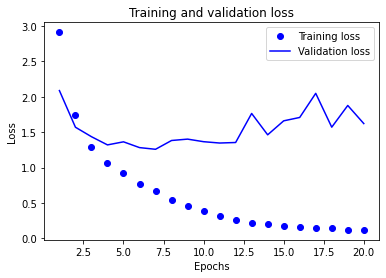

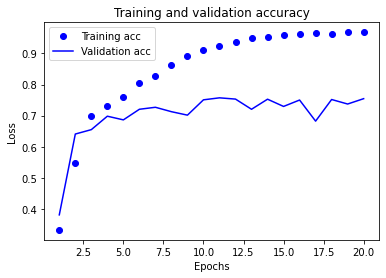

In [46]:
# Plot model_5's loss and accuracy curves
plotTrainingAndValidationLoss(model_5_history)
plotTrainingAndValidationAccuracy(model_5_history)

In [47]:
# Create the sixth model, which is the same as the fifth model but with a sigmoid activation before the output layer
model_6 = models.Sequential()
model_6.add(layers.Dense(60, activation='relu'))
model_6.add(layers.Dense(60, activation='relu'))
model_6.add(layers.Dense(60, activation='relu'))
model_6.add(layers.Dense(60, activation='relu'))
model_6.add(layers.Dense(60, activation='sigmoid'))
model_6.add(layers.Dense(46, activation='softmax'))

model_6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
# Train the fifth model for 20 epochs
model_6_history = model_6.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 3s 145ms/step - loss: 3.1075 - accuracy: 0.2777 - val_loss: 2.3717 - val_accuracy: 0.4874
Epoch 2/20
12/12 [==============================] - 1s 107ms/step - loss: 2.1188 - accuracy: 0.5283 - val_loss: 1.9168 - val_accuracy: 0.5815
Epoch 3/20
12/12 [==============================] - 1s 104ms/step - loss: 1.7718 - accuracy: 0.5973 - val_loss: 1.7194 - val_accuracy: 0.5973
Epoch 4/20
12/12 [==============================] - 1s 102ms/step - loss: 1.5892 - accuracy: 0.6314 - val_loss: 1.6161 - val_accuracy: 0.6310
Epoch 5/20
12/12 [==============================] - 1s 103ms/step - loss: 1.4307 - accuracy: 0.6864 - val_loss: 1.5047 - val_accuracy: 0.6634
Epoch 6/20
12/12 [==============================] - 1s 103ms/step - loss: 1.3096 - accuracy: 0.7176 - val_loss: 1.4423 - val_accuracy: 0.6782
Epoch 7/20
12/12 [==============================] - 1s 101ms/step - loss: 1.1938 - accuracy: 0.7436 - val_loss: 1.3731 - val_accuracy: 0.6988
Epoch 

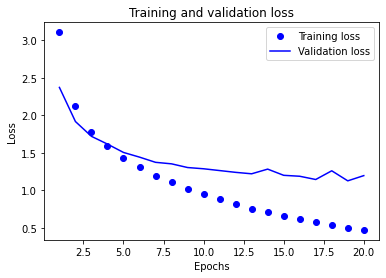

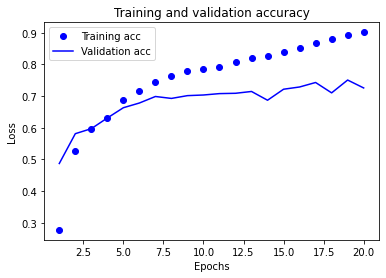

In [49]:
# Plot model_6's loss and accuracy curves
plotTrainingAndValidationLoss(model_6_history)
plotTrainingAndValidationAccuracy(model_6_history)

In [50]:
# Create the seventh model, which is the same as the fifth model but with tanh activation functions
model_7 = models.Sequential()
model_7.add(layers.Dense(60, activation='tanh'))
model_7.add(layers.Dense(60, activation='tanh'))
model_7.add(layers.Dense(60, activation='tanh'))
model_7.add(layers.Dense(60, activation='tanh'))
model_7.add(layers.Dense(60, activation='tanh'))
model_7.add(layers.Dense(46, activation='softmax'))

model_7.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# Train the fifth model for 20 epochs
model_7_history = model_7.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
12/12 [==============================] - 3s 139ms/step - loss: 2.5027 - accuracy: 0.5240 - val_loss: 1.6929 - val_accuracy: 0.6546
Epoch 2/20
12/12 [==============================] - 1s 101ms/step - loss: 1.4036 - accuracy: 0.7170 - val_loss: 1.3655 - val_accuracy: 0.7056
Epoch 3/20
12/12 [==============================] - 1s 100ms/step - loss: 1.0132 - accuracy: 0.8026 - val_loss: 1.2416 - val_accuracy: 0.7187
Epoch 4/20
12/12 [==============================] - 1s 100ms/step - loss: 0.7672 - accuracy: 0.8596 - val_loss: 1.1169 - val_accuracy: 0.7656
Epoch 5/20
12/12 [==============================] - 1s 102ms/step - loss: 0.5954 - accuracy: 0.8991 - val_loss: 1.0767 - val_accuracy: 0.7629
Epoch 6/20
12/12 [==============================] - 1s 99ms/step - loss: 0.4650 - accuracy: 0.9202 - val_loss: 1.0422 - val_accuracy: 0.7771
Epoch 7/20
12/12 [==============================] - 1s 101ms/step - loss: 0.3720 - accuracy: 0.9387 - val_loss: 1.0355 - val_accuracy: 0.7750
Epoch 8

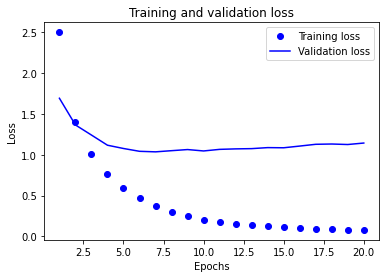

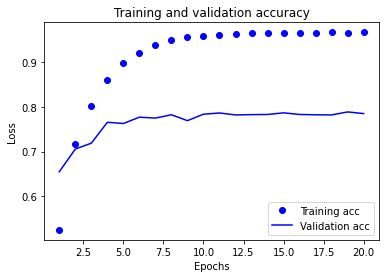

In [52]:
# Plot model_7's loss and accuracy curves
plotTrainingAndValidationLoss(model_7_history)
plotTrainingAndValidationAccuracy(model_7_history)

In [54]:
def getBestPerformingModel(model_list, model_history_list, metric_string='accuracy'):
    """
    Return the model with highest recorded accuracy score from the models in 
    the specified models list.
    """
    max_acc = 0
    best_model_index = 0

    for index,model_history in enumerate(model_history_list):
        best_model_acc = max(model_history.history['val_' + metric_string])
        if best_model_acc > max_acc:
            max_acc = best_model_acc
            best_model_index = index 
    
    return (model_list[best_model_index], best_model_index, max_acc)

In [55]:
def recordBestModel(output_file, best_model, name_line):
    """Record statistics for the best performing model."""
    with open(output_file, 'a') as file:
        best_model_name_line = '\n' + name_line + ': model_' + str(best_model[1] + 1) + '\n'
        file.write(best_model_name_line)
        highest_accuracy_line = 'Highest Accuracy: ' + str(best_model[2]) + '\n'
        file.write(highest_accuracy_line)
        best_model[0].summary(print_fn=lambda x: file.write(x + '\n'))

In [101]:
# Create lists of the models and model histories
model_list = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
model_history_list = [model_1_history, model_2_history, model_3_history, model_4_history, model_5_history, model_6_history, model_7_history]

In [103]:
# Record the highest accuracy, and the parameters of the best performing model
best_model = getBestPerformingModel(model_list, model_history_list, 'accuracy')
recordBestModel(step_1_metrics_out, best_model, 'Best Model')

## Step 3. Classify the Reuter's Data using RNNs

In [57]:
def truncateSequences(sequences, sequence_length=200):
    """
    Truncate the input sequences to the specified sequence_length, padding 
    sequences with zeroes at the end if their length is less than sequence_length.
    """
    results = np.zeros((len(sequences), sequence_length))
    for i, sequence in enumerate(sequences):
        if len(sequence) < sequence_length:
            results[i] = np.pad(sequence, (0, sequence_length - len(sequence)))
        else:
            results[i] = sequence[:sequence_length]
    return results

In [58]:
# Prepare the training/test data
x_RNN_train = truncateSequences(input_train)
x_RNN_test = truncateSequences(input_test)

In [59]:
# Split the training data, using 1/3 of the data as a validation set
partial_X_RNN_train, x_RNN_val, partial_y_RNN_train, y_RNN_val = train_test_split(x_RNN_train, one_hot_train_labels, test_size=0.33)

In [60]:
max_features = 31000

In [61]:
# Create the first RNN model for classifying the Reuter's data
# The model has a single LSTM layer with 46 nodes and default settings: no dropout, tanh activation, etc.
RNN_model_1 = Sequential()
RNN_model_1.add(Embedding(max_features, 46))
RNN_model_1.add(LSTM(46))
RNN_model_1.add(Dense(46, activation='softmax'))

RNN_model_1.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [62]:
# Train the first RNN model
RNN_model_1_history = RNN_model_1.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=64,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/64
12/12 [==============================] - 9s 614ms/step - loss: 3.2539 - acc: 0.2957 - val_loss: 2.6002 - val_acc: 0.3558
Epoch 2/64
12/12 [==============================] - 7s 565ms/step - loss: 2.5089 - acc: 0.3497 - val_loss: 2.4503 - val_acc: 0.3558
Epoch 3/64
12/12 [==============================] - 7s 563ms/step - loss: 2.4172 - acc: 0.3497 - val_loss: 2.4008 - val_acc: 0.3558
Epoch 4/64
12/12 [==============================] - 7s 568ms/step - loss: 2.3869 - acc: 0.3515 - val_loss: 2.4262 - val_acc: 0.3558
Epoch 5/64
12/12 [==============================] - 7s 570ms/step - loss: 2.3607 - acc: 0.3508 - val_loss: 2.3953 - val_acc: 0.3558
Epoch 6/64
12/12 [==============================] - 7s 570ms/step - loss: 2.3520 - acc: 0.3545 - val_loss: 2.3444 - val_acc: 0.3558
Epoch 7/64
12/12 [==============================] - 7s 568ms/step - loss: 2.3339 - acc: 0.3555 - val_loss: 2.3300 - val_acc: 0.3558
Epoch 8/64
12/12 [==============================] - 7s 598ms/step - loss: 2.

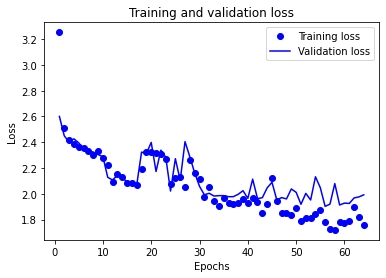

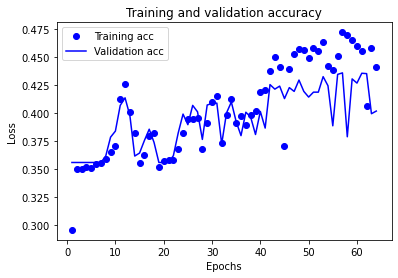

In [63]:
plotTrainingAndValidationLoss(RNN_model_1_history)
plotTrainingAndValidationAccuracy(RNN_model_1_history, 'acc')

Takeaway: This model will be used as a baseline. There's nothing in particular to note: I don't see any overfitting, but there are some spikes in the validation loss and accuracy that should be smoothed out. Overall, accuracy is low compared to the non-RNN NNs. I suspect that this is because the LSTMs need more epochs to train properly, and maybe also has something to do with how the data is preprocessed.

In [64]:
# Create the second RNN model for classifying the Reuter's data
# The model has a single LSTM layer with 46 nodes and a recurrect dropout of 0.2
RNN_model_2 = Sequential()
RNN_model_2.add(Embedding(max_features, 46))
RNN_model_2.add(LSTM(46, recurrent_dropout=0.2))
RNN_model_2.add(Dense(46, activation='softmax'))

RNN_model_2.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [65]:
# Train the second RNN model
RNN_model_2_history = RNN_model_2.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=64,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/64
12/12 [==============================] - 10s 681ms/step - loss: 3.3632 - acc: 0.2957 - val_loss: 2.6059 - val_acc: 0.3558
Epoch 2/64
12/12 [==============================] - 8s 659ms/step - loss: 2.5064 - acc: 0.3497 - val_loss: 2.4629 - val_acc: 0.3558
Epoch 3/64
12/12 [==============================] - 8s 659ms/step - loss: 2.4137 - acc: 0.3497 - val_loss: 2.4358 - val_acc: 0.3558
Epoch 4/64
12/12 [==============================] - 8s 658ms/step - loss: 2.3792 - acc: 0.3498 - val_loss: 2.3857 - val_acc: 0.3626
Epoch 5/64
12/12 [==============================] - 8s 659ms/step - loss: 2.3570 - acc: 0.3577 - val_loss: 2.3661 - val_acc: 0.3558
Epoch 6/64
12/12 [==============================] - 8s 662ms/step - loss: 2.3385 - acc: 0.3548 - val_loss: 2.3669 - val_acc: 0.3750
Epoch 7/64
12/12 [==============================] - 8s 664ms/step - loss: 2.3274 - acc: 0.3618 - val_loss: 2.4214 - val_acc: 0.3558
Epoch 8/64
12/12 [==============================] - 8s 663ms/step - loss: 2

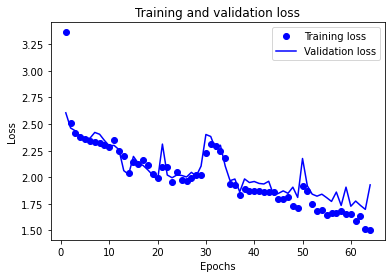

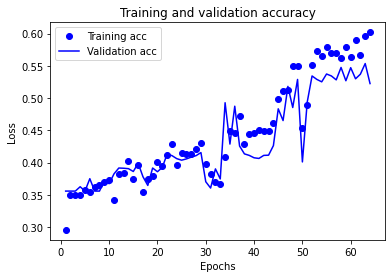

In [66]:
plotTrainingAndValidationLoss(RNN_model_2_history)
plotTrainingAndValidationAccuracy(RNN_model_2_history, 'acc')

Takeaways: adding a dropout value of 0.2 increased the accuracy scores from around 0.4 to around 0.5. There are still some spikes in the validation accuracy / loss values, and I'm not sure why.

In [67]:
# Create the third RNN model for classifying the Reuter's data
# The third model has four LSTM layers. The first three layers have 50 nodes,
# and the last LSTM layer has 40 nodes. Each LSTM layer has a recurrent dropout of 0.2.
RNN_model_3 = Sequential()
RNN_model_3.add(Embedding(max_features, 46))
RNN_model_3.add(LSTM(50, recurrent_dropout=0.2, return_sequences=True))
RNN_model_3.add(LSTM(50, recurrent_dropout=0.2, return_sequences=True))
RNN_model_3.add(LSTM(50, recurrent_dropout=0.2, return_sequences=True))
RNN_model_3.add(LSTM(40, recurrent_dropout=0.2))
RNN_model_3.add(Dense(46, activation='softmax'))

RNN_model_3.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [68]:
# Train the third RNN model
RNN_model_3_history = RNN_model_3.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=64,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/64
12/12 [==============================] - 43s 3s/step - loss: 3.0797 - acc: 0.3080 - val_loss: 2.5805 - val_acc: 0.3565
Epoch 2/64
12/12 [==============================] - 32s 3s/step - loss: 2.4859 - acc: 0.3432 - val_loss: 2.4792 - val_acc: 0.3558
Epoch 3/64
12/12 [==============================] - 32s 3s/step - loss: 2.3593 - acc: 0.3548 - val_loss: 2.3173 - val_acc: 0.3808
Epoch 4/64
12/12 [==============================] - 32s 3s/step - loss: 2.3307 - acc: 0.3332 - val_loss: 2.1969 - val_acc: 0.3562
Epoch 5/64
12/12 [==============================] - 32s 3s/step - loss: 2.0714 - acc: 0.3683 - val_loss: 2.1645 - val_acc: 0.3572
Epoch 6/64
12/12 [==============================] - 32s 3s/step - loss: 2.0260 - acc: 0.3831 - val_loss: 2.0010 - val_acc: 0.3909
Epoch 7/64
12/12 [==============================] - 32s 3s/step - loss: 1.9908 - acc: 0.3931 - val_loss: 2.0457 - val_acc: 0.4020
Epoch 8/64
12/12 [==============================] - 32s 3s/step - loss: 1.9854 - acc: 0.40

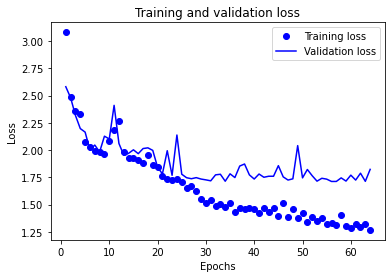

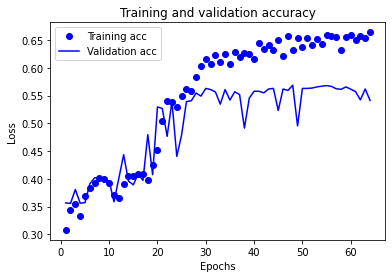

In [69]:
plotTrainingAndValidationLoss(RNN_model_3_history)
plotTrainingAndValidationAccuracy(RNN_model_3_history, 'acc')

Takeaways: increasing the number of layers from one to four seems to have slightly increased the accuracy of the model. The model is also learning faster. There are still some spikes in the validation metrics.

In [70]:
# Create the fourth RNN model for classifying the Reuter's data
# The fourth model also has four LSTM layers. All layers have 80 nodes.
# Each LSTM layer has a recurrent dropout of 0.2.
RNN_model_4 = Sequential()
RNN_model_4.add(Embedding(max_features, 46))
RNN_model_4.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_4.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_4.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_4.add(LSTM(80, recurrent_dropout=0.2))
RNN_model_4.add(Dense(46, activation='softmax'))

RNN_model_4.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [71]:
# Train the fourth RNN model
RNN_model_4_history = RNN_model_4.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=64,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/64
12/12 [==============================] - 64s 5s/step - loss: 2.7809 - acc: 0.3214 - val_loss: 2.4186 - val_acc: 0.3558
Epoch 2/64
12/12 [==============================] - 55s 5s/step - loss: 2.3725 - acc: 0.3493 - val_loss: 2.3846 - val_acc: 0.3734
Epoch 3/64
12/12 [==============================] - 54s 5s/step - loss: 2.3324 - acc: 0.3606 - val_loss: 2.3059 - val_acc: 0.3626
Epoch 4/64
12/12 [==============================] - 55s 5s/step - loss: 2.3177 - acc: 0.3552 - val_loss: 2.4627 - val_acc: 0.3558
Epoch 5/64
12/12 [==============================] - 55s 5s/step - loss: 2.2809 - acc: 0.3638 - val_loss: 2.2796 - val_acc: 0.3821
Epoch 6/64
12/12 [==============================] - 54s 5s/step - loss: 2.3107 - acc: 0.3399 - val_loss: 2.0625 - val_acc: 0.3548
Epoch 7/64
12/12 [==============================] - 54s 5s/step - loss: 2.0745 - acc: 0.3680 - val_loss: 2.0347 - val_acc: 0.4013
Epoch 8/64
12/12 [==============================] - 54s 5s/step - loss: 1.9708 - acc: 0.39

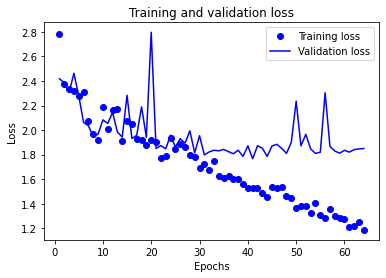

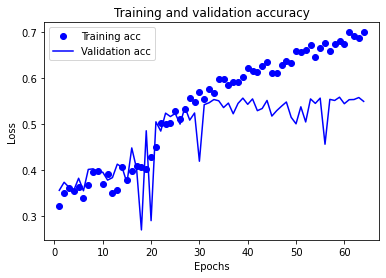

In [72]:
plotTrainingAndValidationLoss(RNN_model_4_history)
plotTrainingAndValidationAccuracy(RNN_model_4_history, 'acc')

Takeaways: increasing the number of nodes in each LSTM layer from 50 to 80 had little effect on the accuracy and loss values. The spikes in the validation values are still present.

In [80]:
# Create the fifth RNN model for classifying the Reuter's data.
# The fifth model is the same as the fourth, but it is run with
# a smaller batch size (512->48).
RNN_model_5 = Sequential()
RNN_model_5.add(Embedding(max_features, 46))
RNN_model_5.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_5.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_5.add(LSTM(80, recurrent_dropout=0.2, return_sequences=True))
RNN_model_5.add(LSTM(80, recurrent_dropout=0.2))
RNN_model_5.add(Dense(46, activation='softmax'))

RNN_model_5.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [81]:
# Train the fifth RNN model
RNN_model_5_history = RNN_model_5.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=64,
                                      batch_size=48,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/64
126/126 [==============================] - 149s 1s/step - loss: 2.4361 - acc: 0.3364 - val_loss: 2.5260 - val_acc: 0.3575
Epoch 2/64
126/126 [==============================] - 139s 1s/step - loss: 2.0882 - acc: 0.3851 - val_loss: 1.9880 - val_acc: 0.4017
Epoch 3/64
126/126 [==============================] - 137s 1s/step - loss: 2.0756 - acc: 0.3837 - val_loss: 2.1236 - val_acc: 0.3990
Epoch 4/64
126/126 [==============================] - 136s 1s/step - loss: 1.9892 - acc: 0.4585 - val_loss: 1.8989 - val_acc: 0.4823
Epoch 5/64
126/126 [==============================] - 137s 1s/step - loss: 1.8370 - acc: 0.5270 - val_loss: 1.7598 - val_acc: 0.5538
Epoch 6/64
126/126 [==============================] - 136s 1s/step - loss: 1.7575 - acc: 0.5654 - val_loss: 1.7993 - val_acc: 0.5140
Epoch 7/64
126/126 [==============================] - 138s 1s/step - loss: 1.8121 - acc: 0.5205 - val_loss: 1.8102 - val_acc: 0.5201
Epoch 8/64
126/126 [==============================] - 138s 1s/step - 

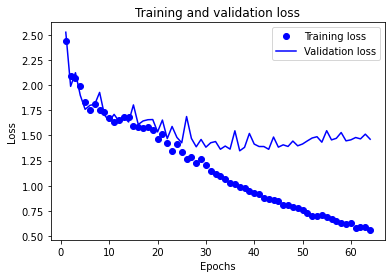

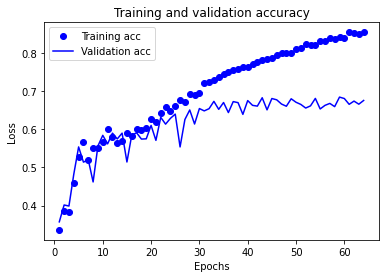

In [83]:
plotTrainingAndValidationLoss(RNN_model_5_history)
plotTrainingAndValidationAccuracy(RNN_model_5_history, 'acc')

Takeaways: decreasing the batch size gave the model another jump in performance, but we start to observe a little overfitting after 30 epochs. Decreasing the batch size also smoothed out the validation metric spikes.

In [82]:
# Create a sixth model, which is the same as the first model 
# with a learning rate of 0.01
RNN_model_6 = Sequential()
RNN_model_6.add(Embedding(max_features, 46))
RNN_model_6.add(LSTM(46))
RNN_model_6.add(Dense(46, activation='softmax'))

opt = keras.optimizers.rmsprop_v2.RMSProp(learning_rate=0.01)
RNN_model_6.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [84]:
# Train the sixth RNN model
RNN_model_6_history = RNN_model_6.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=32,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/32
12/12 [==============================] - 9s 614ms/step - loss: 3.4033 - acc: 0.3198 - val_loss: 2.7884 - val_acc: 0.3558
Epoch 2/32
12/12 [==============================] - 7s 560ms/step - loss: 2.6690 - acc: 0.3497 - val_loss: 2.5325 - val_acc: 0.3558
Epoch 3/32
12/12 [==============================] - 7s 557ms/step - loss: 2.4753 - acc: 0.3497 - val_loss: 2.4458 - val_acc: 0.3592
Epoch 4/32
12/12 [==============================] - 7s 564ms/step - loss: 2.4053 - acc: 0.3563 - val_loss: 2.3963 - val_acc: 0.3558
Epoch 5/32
12/12 [==============================] - 7s 562ms/step - loss: 2.3698 - acc: 0.3613 - val_loss: 2.3761 - val_acc: 0.3629
Epoch 6/32
12/12 [==============================] - 7s 563ms/step - loss: 2.3543 - acc: 0.3630 - val_loss: 2.3674 - val_acc: 0.3653
Epoch 7/32
12/12 [==============================] - 7s 562ms/step - loss: 2.3327 - acc: 0.3636 - val_loss: 2.4241 - val_acc: 0.3700
Epoch 8/32
12/12 [==============================] - 7s 561ms/step - loss: 2.

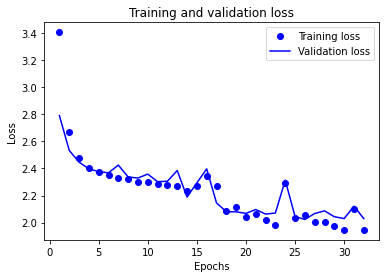

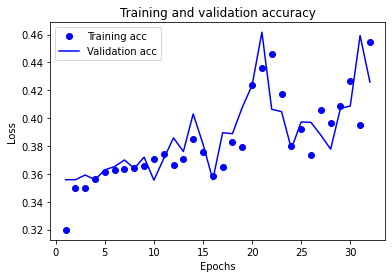

In [85]:
plotTrainingAndValidationLoss(RNN_model_6_history)
plotTrainingAndValidationAccuracy(RNN_model_6_history, 'acc')

In [86]:
# Create an seventh model, which is the same as the first model 
# with a learning rate of 0.0001
RNN_model_7 = Sequential()
RNN_model_7.add(Embedding(max_features, 46))
RNN_model_7.add(LSTM(46))
RNN_model_7.add(Dense(46, activation='softmax'))

opt = keras.optimizers.rmsprop_v2.RMSProp(learning_rate=0.0001)
RNN_model_7.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [87]:
# Train the seventh RNN model
RNN_model_7_history = RNN_model_7.fit(partial_X_RNN_train,
                                      partial_y_RNN_train,
                                      epochs=32,
                                      batch_size=512,
                                      validation_data=(x_RNN_val, y_RNN_val))

Epoch 1/32
12/12 [==============================] - 9s 607ms/step - loss: 3.3655 - acc: 0.3206 - val_loss: 2.6516 - val_acc: 0.3558
Epoch 2/32
12/12 [==============================] - 7s 560ms/step - loss: 2.5360 - acc: 0.3497 - val_loss: 2.4716 - val_acc: 0.3558
Epoch 3/32
12/12 [==============================] - 7s 560ms/step - loss: 2.4256 - acc: 0.3497 - val_loss: 2.4037 - val_acc: 0.3558
Epoch 4/32
12/12 [==============================] - 7s 558ms/step - loss: 2.3763 - acc: 0.3502 - val_loss: 2.3725 - val_acc: 0.3558
Epoch 5/32
12/12 [==============================] - 7s 564ms/step - loss: 2.3560 - acc: 0.3517 - val_loss: 2.3401 - val_acc: 0.3744
Epoch 6/32
12/12 [==============================] - 7s 565ms/step - loss: 2.3445 - acc: 0.3552 - val_loss: 2.3394 - val_acc: 0.3558
Epoch 7/32
12/12 [==============================] - 7s 558ms/step - loss: 2.3099 - acc: 0.3625 - val_loss: 2.4114 - val_acc: 0.3531
Epoch 8/32
12/12 [==============================] - 7s 554ms/step - loss: 2.

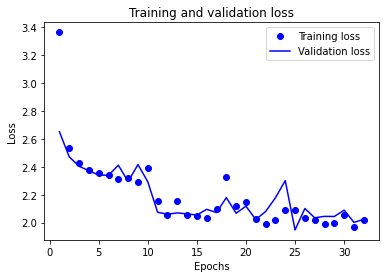

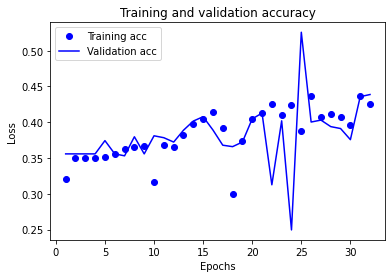

In [88]:
plotTrainingAndValidationLoss(RNN_model_7_history)
plotTrainingAndValidationAccuracy(RNN_model_7_history, 'acc')

In [104]:
# Create lists of the models and model histories
model_list = [RNN_model_1, RNN_model_2, RNN_model_3, RNN_model_4, RNN_model_5, RNN_model_6, RNN_model_7]
model_history_list = [RNN_model_1_history, RNN_model_2_history, RNN_model_3_history, RNN_model_4_history, RNN_model_5_history, RNN_model_6_history, RNN_model_7_history]

In [105]:
# Record information on the best performing model
best_RNN_model = getBestPerformingModel(model_list, model_history_list, 'acc')
recordBestModel(step_1_metrics_out, best_RNN_model, 'Best RNN Model')

## Step 4. Problem 1 Summary

**Problem 1 Takeaways**

For both the basic neural network and RNN models, increasing the number of layers, and to a lesser extent nodes per layer, led to better model performance. Using tanh and relu activation functions, as opposed to sigmoid, also resulted in slightly higher accuracy scores for the basic neural network models. Training the basic models was a cinch, and I was able to use the vectorize method as it exists in the class notebooks to prepare the data. 

When I started building and training the RNN models, I immediately ran into problems with memory and training times. The solution was to switch to Google Colab. The LSTM models performed more poorly than the basic neural network models, and I'm not sure why. I suspect that the LSTM models would benefit from more layers and training data, and training time, than I gave them. Rather than waste time trying to get the best results, I decided to iterate over more versions of the RNN models to discover what architectural choices had the greatest impact. My experiments taught me that the size of the embedding space (vocab) has the greatest impact on model performance, with greater embedding space sizes (vocab) resulting in much higher accuracy scores. Note: I changed the 'embedding space', aka vocab size, parameter on the embedding layer with a gpu runtime and no recurrent dropout, which doesn't appear to work with cudNNLSTM layers. It makes sense that using an embedding size that matches the vocab would lead to better results. The next most important setting was batch size, with smaller batch sizes resulting in better accuracy at the cost of increased training times. My experiments with learning rate were limited, but it appears that going below 0.01 results in degrading performance, although different runs produced different results.

# Part 2. Named Entity Recognition

## 2.1 Download Data and Setup Evaluation Script

In [3]:
# Load the conll2002 Spanish corpus
import nltk
nltk.download('conll2002')
from nltk.corpus import conll2002

train_sents = list(conll2002.iob_sents('esp.train'))
dev_sents = list(conll2002.iob_sents('esp.testa'))
test_sents = list(conll2002.iob_sents('esp.testb'))

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [4]:
# Adapted from Chris Callison-Burch's code stub

def getfeats(word, o, postag):
    """ This takes the word in question and
    the offset with respect to the instance
    word """
    o = str(o)
    features = [
        (word, postag)
    ]
    return features

In [5]:
# Adapted from Chris Callison-Burch's code stub

def word2features(sent, i):
    """ The function generates all features
    for the word at position i in the
    sentence."""
    features = []
    # the window around the token
    for o in [-1,0,1]:
        if i+o >= 0 and i+o < len(sent):
            word = sent[i+o][0]
            postag = sent[i+o][1]
            featlist = getfeats(word, o, postag)
            features.extend(featlist)
    
    return dict(features)

In [6]:
# Prepare training data 
# Taken from Chris Callison-Burch's code stub
train_feats = []
train_labels = []

for sent in train_sents:
    for i in range(len(sent)):
        feats = word2features(sent,i)
        train_feats.append(feats)
        train_labels.append(sent[i][-1])

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_feats)

In [7]:
# Prepare dev data 
# Taken from Chris Callison-Burch's code stub
dev_feats = []
dev_labels = []

for sent in dev_sents:
    for i in range(len(sent)):
        feats = word2features(sent,i)
        dev_feats.append(feats)
        dev_labels.append(sent[i][-1])

X_dev = vectorizer.transform(dev_feats)

In [8]:
# Prepare test data 
# Taken from Chris Callison-Burch's code stub
test_feats = []
test_labels = []

for sent in test_sents:
    for i in range(len(sent)):
        feats = word2features(sent,i)
        test_feats.append(feats)
        test_labels.append(sent[i][-1])

X_test = vectorizer.transform(test_feats)

## 2.2 NER using Different Features

In [9]:
# Define the classifier models
classifier_models = {
    '5NN': KNeighborsClassifier(n_neighbors=5),
    'DTC': DecisionTreeClassifier(random_state=0),
    'LR' : LogisticRegression(random_state=0)
}

In [10]:
def writeResults(y_pred, sentences, file_path):
    j=0
    with open(file_path, 'w') as file:
        for sentence in sentences:
            for i in range(len(sentence)):
                word = sentence[i][0]
                gold = sentence[i][-1]
                pred = y_pred[j]
                j += 1
                file.write('{}\t{}\t{}\n'.format(word,gold,pred))
        file.write('\n')

In [11]:
# Train each of the models and evaluate them using the dev data
for classifier_name,classifier in classifier_models.items():
    print('training ' + classifier_name + ' classifier...')
    classifier.fit(X_train, train_labels)

    print('evaluating ' + classifier_name + ' classifier with training data...')
    y_pred_train = classifier.predict(X_train)
    print('evaluating ' + classifier_name + ' classifier with dev data...')
    y_pred_dev = classifier.predict(X_dev)

    print('writing training results to file...')
    train_results_out = os.path.join(os.getcwd(), 'Part2Results', 'train_results_' + classifier_name + '.txt')
    writeResults(y_pred_train, train_sents, train_results_out)

    print('writing dev results to file...')
    dev_results_out = os.path.join(os.getcwd(), 'Part2Results', 'dev_results_' + classifier_name + '.txt')
    writeResults(y_pred_dev, dev_sents, dev_results_out)

training 5NN classifier...
evaluating 5NN classifier with training data...
evaluating 5NN classifier with dev data...
writing training results to file...
writing dev results to file...
training DTC classifier...
evaluating DTC classifier with training data...
evaluating DTC classifier with dev data...
writing training results to file...
writing dev results to file...
training LR classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


evaluating LR classifier with training data...
evaluating LR classifier with dev data...
writing training results to file...
writing dev results to file...


In [47]:
# Get the training results for the K-Nearest Neighbors model
%run -i conlleval.py './Part2Results/train_results_5NN.txt'

processed 264715 tokens with 18797 phrases; found: 18890 phrases; correct: 7514.
accuracy:  92.74%; precision:  39.78%; recall:  39.97%; FB1:  39.88
              LOC: precision:  43.01%; recall:  47.63%; FB1:  45.20  5441
             MISC: precision:  23.61%; recall:  23.70%; FB1:  23.66  2181
              ORG: precision:  49.58%; recall:  47.94%; FB1:  48.75  7146
              PER: precision:  27.07%; recall:  25.83%; FB1:  26.44  4122


In [48]:
# Get the dev results for the K-Nearest Neighbors model
%run -i conlleval.py './Part2Results/dev_results_5NN.txt'

processed 52923 tokens with 4351 phrases; found: 4885 phrases; correct: 1121.
accuracy:  86.63%; precision:  22.95%; recall:  25.76%; FB1:  24.27
              LOC: precision:  19.04%; recall:  40.45%; FB1:  25.89  2090
             MISC: precision:   8.47%; recall:   6.97%; FB1:   7.64  366
              ORG: precision:  32.80%; recall:  34.82%; FB1:  33.78  1805
              PER: precision:  16.03%; recall:   8.18%; FB1:  10.83  624


In [49]:
# Get the training results for the Decision Tree model
%run -i conlleval.py './Part2Results/train_results_DTC.txt'

processed 264715 tokens with 18797 phrases; found: 20966 phrases; correct: 16794.
accuracy:  98.77%; precision:  80.10%; recall:  89.34%; FB1:  84.47
              LOC: precision:  85.42%; recall:  93.95%; FB1:  89.48  5404
             MISC: precision:  72.69%; recall:  85.00%; FB1:  78.36  2541
              ORG: precision:  83.29%; recall:  90.22%; FB1:  86.61  8005
              PER: precision:  73.05%; recall:  84.80%; FB1:  78.48  5016


In [50]:
# Get the dev results for the Decision Tree model
%run -i conlleval.py './Part2Results/dev_results_DTC.txt'

processed 52923 tokens with 4351 phrases; found: 3701 phrases; correct: 1472.
accuracy:  89.52%; precision:  39.77%; recall:  33.83%; FB1:  36.56
              LOC: precision:  44.78%; recall:  49.29%; FB1:  46.93  1083
             MISC: precision:  18.39%; recall:  14.38%; FB1:  16.14  348
              ORG: precision:  46.05%; recall:  43.53%; FB1:  44.75  1607
              PER: precision:  27.60%; recall:  14.98%; FB1:  19.42  663


In [51]:
# Get the training results for the Logistic Regression model
%run -i conlleval.py './Part2Results/train_results_LR.txt'

processed 264715 tokens with 18797 phrases; found: 12243 phrases; correct: 4838.
accuracy:  91.93%; precision:  39.52%; recall:  25.74%; FB1:  31.17
              LOC: precision:  44.36%; recall:  25.06%; FB1:  32.02  2775
             MISC: precision:  16.09%; recall:   9.99%; FB1:  12.32  1349
              ORG: precision:  45.09%; recall:  30.24%; FB1:  36.20  4957
              PER: precision:  36.53%; recall:  26.73%; FB1:  30.87  3162


In [52]:
# Get the dev results for the Logistic Regression model
%run -i conlleval.py './Part2Results/dev_results_LR.txt'

processed 52923 tokens with 4351 phrases; found: 2225 phrases; correct: 749.
accuracy:  88.19%; precision:  33.66%; recall:  17.21%; FB1:  22.78
              LOC: precision:  39.66%; recall:  26.12%; FB1:  31.50  648
             MISC: precision:   5.24%; recall:   2.47%; FB1:   3.36  210
              ORG: precision:  39.05%; recall:  22.35%; FB1:  28.43  973
              PER: precision:  25.63%; recall:   8.27%; FB1:  12.50  394


## 2.3 Run Model on Test Set

In [56]:
# Run the best perform model--the decision tree model--on the test set
print('evaluating DTC classifier with test data...')
y_pred_train = classifier.predict(X_train)
print('writing test results to file...')
train_results_out = os.path.join(os.getcwd(), 'Part2Results', 'test_results_DTC.txt')
writeResults(y_pred_train, train_sents, train_results_out)

evaluating DTC classifier with test data...
writing test results to file...


In [58]:
# Get the test results for the Decision Tree model
%run -i conlleval.py './Part2Results/test_results_DTC.txt'

processed 264715 tokens with 18797 phrases; found: 12243 phrases; correct: 4838.
accuracy:  91.93%; precision:  39.52%; recall:  25.74%; FB1:  31.17
              LOC: precision:  44.36%; recall:  25.06%; FB1:  32.02  2775
             MISC: precision:  16.09%; recall:   9.99%; FB1:  12.32  1349
              ORG: precision:  45.09%; recall:  30.24%; FB1:  36.20  4957
              PER: precision:  36.53%; recall:  26.73%; FB1:  30.87  3162
